In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import ast
import pandas as pd
from pandas import Timestamp
from datetime import datetime
import os, re, sys

# Google Colab:
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/donorAskAmount/src')
DATA_DIR = '/content/drive/MyDrive/donorAskAmount/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data processing
We must replace NaNs directly with 0. It looks like some NaNs were accidentally converted to the string "nan", somehow. I found it faster to do this in Google Sheets than in Pandas. Also, empty cells should be 0. It was not possible to one-hot encode every column that I would have wanted, due to memory concerns.

Recipient type has not been one-hot encoded. For now, I will be assigning "CAND"="1", "COMM"="0".
Party has also not been one hot encoded. 0 = democrat, 1 = republican, 0.5=everything else.

election type was also not one-hot encoded, so I did 0=NaN, G=2, P=1, S=3, R=4

In [ ]:
datapath = os.path.join(DATA_DIR, 'dataset_repeat_clean_old.csv')

dropcols=['transaction.id', 'bonica.cid', 'recipient.state', 'cycle', 'seat', 'recipient.name', 'bonica.rid', 'repeat_donor']

df=pd.read_csv(datapath)
df.drop(columns=dropcols, inplace=True)
# Find columns that start with 'state_'
statecols = [col for col in df.columns if col.startswith('state_')]
# Drop these columns from the DataFrame
df.drop(columns=statecols, inplace=True)

# Convert empty strings to NaN
df.replace('', np.nan, inplace=True)

# Now replace all NaN values with 0
df.fillna(0, inplace=True)

df = df[df['has_location'] == 1]

# Handle dates
def parse_timestamp_list(ts_list_str):
    try:
        # Regex to find all date-time strings in the input
        date_times = re.findall(r"Timestamp\('([^']+)'\)", ts_list_str)
        # Convert each found date-time string to a datetime object
        return [pd.to_datetime(date_time) for date_time in date_times]
    except Exception as e:
        print(f"Error parsing {ts_list_str}: {e}")
        return None

def getYear(list_dates):
  return [date.year for date in list_dates]

def getMonth(list_dates):
  return [date.month for date in list_dates]

def getDay(list_dates):
  return [date.day for date in list_dates]

# Apply this function to the specific column
# Assume 'date_list_column' is the name of your column containing the timestamp lists
df['date'] = df['date'].apply(parse_timestamp_list)
print(type(df['date'][3][0]))
df['year'] = df['date'].apply(getYear)
df['month'] = df['date'].apply(getMonth)
df['day'] = df['date'].apply(getDay)

#Make sure all columns has correct format and indices are aligned
def ensure_list(data):
    if isinstance(data, str):
        try:
            return ast.literal_eval(data)
        except ValueError:
            return []  # or handle the error as appropriate
    return data

df['adjusted_amount'] = df['adjusted_amount'].apply(ensure_list)
df.reset_index(drop=True, inplace=True)

df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,amount,date,recipient.party,recipient.type,election.type,candidate.cfscore,adjusted_amount,seat_federal:committee,seat_federal:house,seat_federal:president,...,latitude,longitude,contributor.cfscore,contributor.gender_F,contributor.gender_M,contributor.gender_U,has_location,year,month,day
0,"[1000.0, 300.0, 1000.0, 125.0, 433.41]","[1995-09-05 00:00:00, 1995-10-02 00:00:00, 199...","[1, 1, 1, 1, 1]","[1, 1, 1, 1, 1]","[1, 1, 1, 1, 0]","[-0.6, -0.6, -0.6, -0.6, -0.6]","[1973.24, 591.97, 1973.24, 246.66, 831.93]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",...,41.972580,-87.731926,-0.62,0,1,0,1,"[1995, 1995, 1995, 1995, 1996]","[9, 10, 9, 11, 2]","[5, 2, 20, 30, 9]"
1,"[200.0, 100.0, 200.0]","[1996-03-08 00:00:00, 1996-04-24 00:00:00, 199...","[1, 0, 0]","[1, 1, 1]","[0, 0, 0]","[-0.82, -0.75, -0.66]","[383.9, 191.95, 383.9]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,26.122038,-80.153473,-0.77,0,1,0,1,"[1996, 1996, 1996]","[3, 4, 3]","[8, 24, 6]"
2,"[193.63, 906.37, 1100.0]","[1998-11-17 00:00:00, 1998-11-17 00:00:00, 199...","[0, 0, 0]","[1, 1, 1]","[0, 0, 0]","[0.0, 0.0, 0.0]","[352.73, 1651.13, 2003.86]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,37.905380,-86.886192,0.00,0,1,0,1,"[1998, 1998, 1998]","[11, 11, 9]","[17, 17, 29]"
3,"[600.0, 2440.0, 1500.0, 317.83, 239.68, 900.0,...","[1998-02-03 00:00:00, 1998-07-15 00:00:00, 199...","[2, 2, 2, 2, 2, 2, 2]","[1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1093.02, 4444.93, 2795.39, 578.99, 436.62, 16...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,36.676071,-86.136497,0.00,0,1,0,1,"[1998, 1998, 1997, 1998, 1998, 1998, 1998]","[2, 7, 12, 6, 11, 4, 11]","[3, 15, 9, 11, 22, 2, 23]"
4,"[100.0, 50.0, 95.0, 150.0, 770.06, 75.0]","[1998-03-18 00:00:00, 1998-06-01 00:00:00, 199...","[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[182.17, 91.08, 173.06, 273.25, 1402.81, 136.63]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",...,37.081390,-87.771431,0.00,0,1,0,1,"[1998, 1998, 1998, 1998, 1998, 1998]","[3, 6, 5, 3, 1, 5]","[18, 1, 6, 16, 30, 18]"


Preparing data for RNN input (scaling, train test split)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Flattening the list of lists to fit the scaler
all_values = np.concatenate(df['adjusted_amount'].values)

# Scaling the values between 0 and 1
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(all_values.reshape(-1, 1)).flatten()

# Reconstructing the original list structure
offset = 0
for idx, lst in enumerate(df['adjusted_amount']):
    length = len(lst)
    df.at[idx, 'adjusted_amount'] = scaled_values[offset:offset + length]
    offset += length

# List of specific columns to expand
columns_to_expand = [
    'contributor.zipcode', 'recipient.name', 'bonica.rid',
    'latitude', 'longitude', 'contributor.cfscore',
    'contributor.gender_F', 'contributor.gender_M', 'contributor.gender_U'
]

# Define the function to replicate non-list entries
def replicate_if_not_list(entry, reference_length):
    if isinstance(entry, list):
        return entry
    else:
        return [entry] * reference_length

# Apply this function only to the specified columns
for col in columns_to_expand:
    if col in df.columns:  # Ensure the column exists in DataFrame
        df[col] = df.apply(lambda row: replicate_if_not_list(row[col], len(row['adjusted_amount'])), axis=1)

#We don't need "date" anymore since we added the year month day cols
df.drop(columns=['date', 'amount', 'has_location'], inplace=True)


#Make sure all columns have correct format and indices are aligned
def ensure_list(data):
    if isinstance(data, str):
      return ast.literal_eval(data)

    elif (isinstance(data, list)):
      return data

    elif (isinstance(data, np.ndarray) or isinstance(data, np.array)):
      return data.tolist()

    else:
      raise NameError("Data should be lists, arrays, or strings")
      return []

for col in df.columns:
  try:
    df[col] = df[col].apply(ensure_list)
  except:
    print(f"Bad data in {col}")
    print(type(df[col][1]))

df.reset_index(drop=True, inplace=True)

def remove_third_parties(entry):
  for i in range(0, len(entry)):
    if entry[i]==2 or entry[i]==200:
      entry[i] = 1.0
    elif entry[i]==1 or entry[i]==100:
      entry[i] = 0.0
    else:
      entry[i] = 0.5
  return entry

# Apply the function to each list in the party column to remove 3rd parties
# Republicans = 1, democrats = 0, everyone else = 0.5, this gives us a notion of order
df['recipient.party'] = df['recipient.party'].apply(remove_third_parties)


df.head()

,recipient.party,recipient.type,election.type,candidate.cfscore,adjusted_amount,seat_federal:committee,seat_federal:house,seat_federal:president,seat_federal:senate,seat_local:council,...,contributor.zipcode,latitude,longitude,contributor.cfscore,contributor.gender_F,contributor.gender_M,contributor.gender_U,year,month,day
0,"[0.0, 0.0, 0.0, 0.0, 0.0]","[1, 1, 1, 1, 1]","[1, 1, 1, 1, 0]","[-0.6, -0.6, -0.6, -0.6, -0.6]","[0.06400862967772174, 0.06175578053148661, 0.0...","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0]","[41.97258, 41.97258, 41.97258, 41.97258, 41.97...","[-87.731926, -87.731926, -87.731926, -87.73192...","[-0.62, -0.62, -0.62, -0.62, -0.62]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]","[1995, 1995, 1995, 1995, 1996]","[9, 10, 9, 11, 2]","[5, 2, 20, 30, 9]"
1,"[0.0, 0.5, 0.5]","[1, 1, 1]","[0, 0, 0]","[-0.82, -0.75, -0.66]","[0.06141641869646728, 0.061103348555495686, 0....","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[33301, 33301, 33301]","[26.122038, 26.122038, 26.122038]","[-80.153473, -80.153473, -80.153473]","[-0.77, -0.77, -0.77]","[0, 0, 0]","[1, 1, 1]","[0, 0, 0]","[1996, 1996, 1996]","[3, 4, 3]","[8, 24, 6]"
2,"[0.5, 0.5, 0.5]","[1, 1, 1]","[0, 0, 0]","[0.0, 0.0, 0.0]","[0.06136558047664918, 0.06348326878630023, 0.0...","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[42351, 42351, 42351]","[37.90538, 37.90538, 37.90538]","[-86.886192, -86.886192, -86.886192]","[0.0, 0.0, 0.0]","[0, 0, 0]","[1, 1, 1]","[0, 0, 0]","[1998, 1998, 1998]","[11, 11, 9]","[17, 17, 29]"
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.06257299227482507, 0.06803995208844371, 0.0...","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",...,"[42164, 42164, 42164, 42164, 42164, 42164, 42164]","[36.676071, 36.676071, 36.676071, 36.676071, 3...","[-86.136497, -86.136497, -86.136497, -86.13649...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0]","[1998, 1998, 1997, 1998, 1998, 1998, 1998]","[2, 7, 12, 6, 11, 4, 11]","[3, 15, 9, 11, 22, 2, 23]"
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.06108739739124092, 0.060938829747890555, 0....","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",...,"[42408, 42408, 42408, 42408, 42408, 42408]","[37.08139, 37.08139, 37.08139, 37.08139, 37.08...","[-87.771431, -87.771431, -87.771431, -87.77143...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0]","[1998, 1998, 1998, 1998, 1998, 1998]","[3, 6, 5, 3, 1, 5]","[18, 1, 6, 16, 30, 18]"


In [ ]:
# Calculate maximum list length only from columns that actually contain lists
max_length = max(df['election.type'].apply(len))
print(max_length)

def pad_and_convert_to_array(entry):
        num_zeros_to_add = max_length - len(entry)
        if num_zeros_to_add <= 0:
          return np.array(entry, dtype=np.dtype(float))
        padded_list = entry + [0] * num_zeros_to_add
        return np.array(padded_list, dtype=np.dtype(float))

# Apply the function to each list in every column that contains lists
for col in df.columns:
    # Apply padding only to columns with list entries
    if isinstance(df[col].iloc[0], list):
        df[col] = df[col].apply(pad_and_convert_to_array)

#debugging
for col in df.columns:
    print(f"Column: {col}")
    sample_entry = df[col][1]  # Just take the first entry for example
    if isinstance(sample_entry, list):
        print(f"First list entry before padding: {sample_entry}")
        padded_entry = pad_and_convert_to_array(sample_entry)
        print(f"First list entry after padding: {padded_entry}")

df.head()

381
Column: recipient.party
Column: recipient.type
Column: election.type
Column: candidate.cfscore
Column: adjusted_amount
Column: seat_federal:committee
Column: seat_federal:house
Column: seat_federal:president
Column: seat_federal:senate
Column: seat_local:council
Column: seat_other
Column: seat_state:committee
Column: seat_state:governor
Column: seat_state:judicial
Column: seat_state:lower
Column: seat_state:office
Column: seat_state:upper
Column: contributor.zipcode
Column: latitude
Column: longitude
Column: contributor.cfscore
Column: contributor.gender_F
Column: contributor.gender_M
Column: contributor.gender_U
Column: year
Column: month
Column: day


,recipient.party,recipient.type,election.type,candidate.cfscore,adjusted_amount,seat_federal:committee,seat_federal:house,seat_federal:president,seat_federal:senate,seat_local:council,...,contributor.zipcode,latitude,longitude,contributor.cfscore,contributor.gender_F,contributor.gender_M,contributor.gender_U,year,month,day
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.6, -0.6, -0.6, -0.6, -0.6, 0.0, 0.0, 0.0, ...","[0.06400862967772174, 0.06175578053148661, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[41.97258, 41.97258, 41.97258, 41.97258, 41.97...","[-87.731926, -87.731926, -87.731926, -87.73192...","[-0.62, -0.62, -0.62, -0.62, -0.62, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1995.0, 1995.0, 1995.0, 1995.0, 1996.0, 0.0, ...","[9.0, 10.0, 9.0, 11.0, 2.0, 0.0, 0.0, 0.0, 0.0...","[5.0, 2.0, 20.0, 30.0, 9.0, 0.0, 0.0, 0.0, 0.0..."
1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.82, -0.75, -0.66, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.06141641869646728, 0.061103348555495686, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[33301.0, 33301.0, 33301.0, 0.0, 0.0, 0.0, 0.0...","[26.122038, 26.122038, 26.122038, 0.0, 0.0, 0....","[-80.153473, -80.153473, -80.153473, 0.0, 0.0,...","[-0.77, -0.77, -0.77, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1996.0, 1996.0, 1996.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.0, 4.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.0, 24.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06136558047664918, 0.06348326878630023, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[42351.0, 42351.0, 42351.0, 0.0, 0.0, 0.0, 0.0...","[37.90538, 37.90538, 37.90538, 0.0, 0.0, 0.0, ...","[-86.886192, -86.886192, -86.886192, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1998.0, 1998.0, 1998.0, 0.0, 0.0, 0.0, 0.0, 0...","[11.0, 11.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[17.0, 17.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06257299227482507, 0.06803995208844371, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[42164.0, 

In [ ]:
# Check that all entries are now arrays and have the same length
for col in df.columns:
    if isinstance(df[col].iloc[0], np.ndarray):
        all_lengths = df[col].apply(len)
        if all_lengths.nunique() == 1:
            print(f"All entries in column {col} are of length {all_lengths.iloc[0]}")
        else:
          max_length = max(df[col].apply(len))
          min_length = min(df[col].apply(len))
          print(f"Column {col} has entries of lengths from {min_length} to {max_length}")
df.head()

All entries in column recipient.party are of length 381
All entries in column recipient.type are of length 381
All entries in column election.type are of length 381
All entries in column candidate.cfscore are of length 381
All entries in column adjusted_amount are of length 381
All entries in column seat_federal:committee are of length 381
All entries in column seat_federal:house are of length 381
All entries in column seat_federal:president are of length 381
All entries in column seat_federal:senate are of length 381
All entries in column seat_local:council are of length 381
All entries in column seat_other are of length 381
All entries in column seat_state:committee are of length 381
All entries in column seat_state:governor are of length 381
All entries in column seat_state:judicial are of length 381
All entries in column seat_state:lower are of length 381
All entries in column seat_state:office are of length 381
All entries in column seat_state:upper are of length 381
All entries i

,recipient.party,recipient.type,election.type,candidate.cfscore,adjusted_amount,seat_federal:committee,seat_federal:house,seat_federal:president,seat_federal:senate,seat_local:council,...,contributor.zipcode,latitude,longitude,contributor.cfscore,contributor.gender_F,contributor.gender_M,contributor.gender_U,year,month,day
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.6, -0.6, -0.6, -0.6, -0.6, 0.0, 0.0, 0.0, ...","[0.06400862967772174, 0.06175578053148661, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[41.97258, 41.97258, 41.97258, 41.97258, 41.97...","[-87.731926, -87.731926, -87.731926, -87.73192...","[-0.62, -0.62, -0.62, -0.62, -0.62, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1995.0, 1995.0, 1995.0, 1995.0, 1996.0, 0.0, ...","[9.0, 10.0, 9.0, 11.0, 2.0, 0.0, 0.0, 0.0, 0.0...","[5.0, 2.0, 20.0, 30.0, 9.0, 0.0, 0.0, 0.0, 0.0..."
1,"[0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.82, -0.75, -0.66, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.06141641869646728, 0.061103348555495686, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[33301.0, 33301.0, 33301.0, 0.0, 0.0, 0.0, 0.0...","[26.122038, 26.122038, 26.122038, 0.0, 0.0, 0....","[-80.153473, -80.153473, -80.153473, 0.0, 0.0,...","[-0.77, -0.77, -0.77, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1996.0, 1996.0, 1996.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.0, 4.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.0, 24.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06136558047664918, 0.06348326878630023, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[42351.0, 42351.0, 42351.0, 0.0, 0.0, 0.0, 0.0...","[37.90538, 37.90538, 37.90538, 0.0, 0.0, 0.0, ...","[-86.886192, -86.886192, -86.886192, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1998.0, 1998.0, 1998.0, 0.0, 0.0, 0.0, 0.0, 0...","[11.0, 11.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[17.0, 17.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06257299227482507, 0.06803995208844371, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[42164.0, 

In [ ]:
# Prepare target (y) and input features (X)
features=df.drop(columns=['adjusted_amount'])
target=df['adjusted_amount']

X = np.stack(features.values)  # Convert lists to numpy array
y = np.stack(target.values)    # Convert lists to numpy array
print(type(X), type(y))
print(X.shape, y.shape)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=109)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=109)
print("Train Val Test shapes:")
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(13625, 26) (13625, 381)
Train Val Test shapes:
(9809, 26) (9809, 381)
(2453, 26) (2453, 381)
(1363, 26) (1363, 381)


### Flattening
- Defines a function to flatten multi-dimensional data samples into 1D arrays.
- Uses the function on both PCA-transformed and original datasets for training, validation, and test splits.
- Converts target arrays (`y_pca_*` and `y_*`) to float for all datasets.

In [ ]:
def flatten_samples(samples):
    flattened_samples = []
    for sample in samples:
        # Flatten each sample to a 1D list
        flat_sample = np.hstack(sample)
        flattened_samples.append(flat_sample)
    return np.array(flattened_samples, dtype=np.dtype(float))

# Apply flattening and conversion to float32
X_train_flat = flatten_samples(X_train)
X_val_flat = flatten_samples(X_val)
X_test_flat = flatten_samples(X_test)

# Ensure target arrays are also correctly formatted
y_train = np.array(y_train, dtype=np.dtype(float))
y_val = np.array(y_val, dtype=np.dtype(float))
y_test = np.array(y_test, dtype=np.dtype(float))

print(X_train_flat, y_train)
print(X_val_flat, y_val)
print(X_test_flat, y_test)


[[0.5 0.5 0.5 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 ...
 [0.5 0.5 1.  ... 0.  0.  0. ]
 [1.  1.  1.  ... 0.  0.  0. ]
 [1.  1.  1.  ... 0.  0.  0. ]] [[0.06079106 0.06079106 0.06079106 ... 0.         0.         0.        ]
 [0.06513875 0.06288897 0.06288897 ... 0.         0.         0.        ]
 [0.06161579 0.06159487 0.         ... 0.         0.         0.        ]
 ...
 [0.06172949 0.06110335 0.09050205 ... 0.         0.         0.        ]
 [0.0642934  0.06219153 0.06400863 ... 0.         0.         0.        ]
 [0.06155975 0.06152033 0.06152033 ... 0.         0.         0.        ]]
[[1.  0.  0.  ... 0.  0.  0. ]
 [1.  0.5 0.5 ... 0.  0.  0. ]
 [0.  0.5 0.5 ... 0.  0.  0. ]
 ...
 [0.  0.5 0.  ... 0.  0.  0. ]
 [1.  0.  0.  ... 0.  0.  0. ]
 [1.  1.  0.  ... 0.  0.  0. ]] [[0.06123595 0.06094225 0.         ... 0.         0.         0.        ]
 [0.06243264 0.06110335 0.06157295 ... 0.         0.         0.        ]
 [0.06326088 0.06161579 0.

### Preparing the Dataset
- Reshapes the flattened feature arrays to include a single time step, preparing them for RNN input.
- Converts arrays into TensorFlow datasets for efficient training, validation, and testing.
- Implements batching and prefetching for the datasets to optimize loading.
- Repeats the reshaping and dataset creation for PCA-transformed data.

In [ ]:
import tensorflow as tf
#Dataset pipeline
X_train_rnn = X_train_flat.reshape((X_train_flat.shape[0], 1, X_train_flat.shape[1]))
X_val_rnn = X_val_flat.reshape((X_val_flat.shape[0], 1, X_val_flat.shape[1]))
X_test_rnn = X_test_flat.reshape((X_test_flat.shape[0], 1, X_test_flat.shape[1]))

print(X_train_rnn.shape)
print(X_val_rnn.shape)
print(X_test_rnn.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((
    X_train_rnn,
    y_train
))

validate_dataset = tf.data.Dataset.from_tensor_slices((
    X_val_rnn,
    y_val
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    X_test_rnn,
    y_test
))

# Parameters
BATCH_SIZE = 128
PREFETCH_BUFFER = tf.data.AUTOTUNE

train_data = train_dataset.shuffle(len(y_train)).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)

# Shuffling is not necessary for validation/test data
validation_data = validate_dataset.batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)

(9809, 1, 9906)
(2453, 1, 9906)
(1363, 1, 9906)


The first iteration of the model architecture used a deep singe-directional LSTM, but this resulted in very low accuracy, and low loss, interestingly enough.
We experimented with layers and dropout rates of various sizes, and found that 100 and 0.2 are the best, respectively.

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(1, X_train_flat.shape[1]), dtype="float32"),
    LSTM(100, activation='relu', kernel_initializer=GlorotUniform()),
    Dropout(0.20),
    Dense(100, activation=None, kernel_initializer=GlorotUniform()),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.20),
    Dense(y_train.shape[1], activation = 'sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               4002800   
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                      

### Model Training
- Adjusts the learning rate based on validation loss, reducing it by 50% after 5 epochs with no improvement.
- Monitors validation accuracy to stop training early if no improvement occurs after 5 epochs, restoring the best weights.

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])


history = model.fit(train_data, epochs=20,
                    validation_data=validation_data,
                    callbacks=[lr_reduction, early_stopping])

model.save(os.path.join(DATA_DIR,'RNN.keras'))

Epoch 1/20
77/77 [==============================] - 4s 13ms/step - loss: 0.1088 - accuracy: 0.0074 - val_loss: 0.1494 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
77/77 [==============================] - 1s 10ms/step - loss: 0.0263 - accuracy: 0.0170 - val_loss: 0.0719 - val_accuracy: 0.5243 - lr: 0.0010
Epoch 3/20
77/77 [==============================] - 1s 9ms/step - loss: 0.0103 - accuracy: 0.0403 - val_loss: 0.0341 - val_accuracy: 0.5243 - lr: 0.0010
Epoch 4/20
77/77 [==============================] - 1s 9ms/step - loss: 0.0047 - accuracy: 0.0889 - val_loss: 0.0203 - val_accuracy: 0.5243 - lr: 0.0010
Epoch 5/20
77/77 [==============================] - 1s 9ms/step - loss: 0.0033 - accuracy: 0.1512 - val_loss: 0.0118 - val_accuracy: 0.5243 - lr: 0.0010
Epoch 6/20
77/77 [==============================] - 1s 9ms/step - loss: 0.0018 - accuracy: 0.2100 - val_loss: 0.0080 - val_accuracy: 0.5243 - lr: 0.0010
Epoch 7/20
77/77 [==============================] - 1s 9ms/step - loss: 0.00

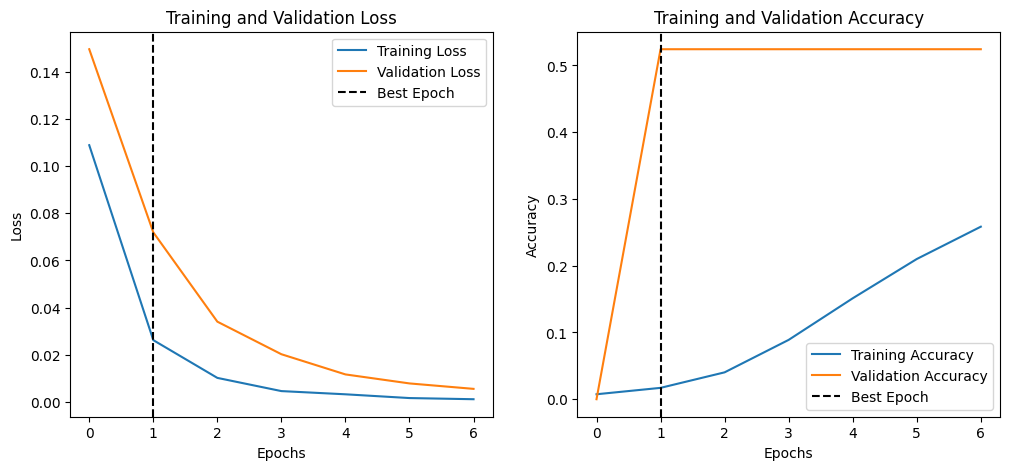

In [ ]:
# Extracting values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

best_epoch = early_stopping.stopped_epoch - early_stopping.patience
if best_epoch < 1:
    best_epoch = early_stopping.stopped_epoch  # Adjust if early stopping never triggered


# Plotting
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=best_epoch, color='black', linestyle='--', label='Best Epoch')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=best_epoch, color='black', linestyle='--', label='Best Epoch')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
test_data = test_dataset.batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)
model.evaluate(test_data)

11/11 [==============================] - 0s 5ms/step - loss: 0.0719 - accuracy: 0.4996


[0.07190043479204178, 0.49963316321372986]

In [ ]:
index = 0
sample = X_test_rnn[index:index+1]  # Use slicing to keep the sample in batch shape
true_target = y_test[index]

# Predict the sample using the model
prediction = model.predict(sample)

# Print the prediction and the true target
print("Predicted value:", prediction)
print("Actual value:", true_target)

1/1 [==============================] - 0s 184ms/step
Predicted value: [[0.29915527 0.27724308 0.27362683 0.26354212 0.28902236 0.26487523
  0.2598657  0.2661242  0.26592022 0.2568655  0.2877103  0.27906457
  0.2719234  0.2860425  0.26055256 0.28366545 0.2692525  0.28064346
  0.2863705  0.25182864 0.25270677 0.26040456 0.28247324 0.24080412
  0.26717663 0.25818923 0.2447461  0.2778103  0.2548952  0.2880575
  0.28793058 0.2696782  0.28167123 0.25006998 0.2721338  0.27492884
  0.25429538 0.26629362 0.25063407 0.28739524 0.26807582 0.23877084
  0.28820717 0.27129686 0.2600618  0.26459366 0.272853   0.26102498
  0.28170967 0.26216266 0.28014004 0.28025797 0.27197254 0.2660924
  0.27510077 0.26869825 0.26832372 0.2743067  0.26842895 0.27589813
  0.27427736 0.26501375 0.2878446  0.28341094 0.2692689  0.2508909
  0.2694946  0.2677432  0.26800418 0.28177735 0.25377542 0.27853444
  0.25173348 0.28110617 0.2571261  0.2593404  0.26337737 0.25411284
  0.25809062 0.26565492 0.25650796 0.26235068 0.2